In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200

In [2]:
import sim_steady_state_fast as sim

## Point 1: what is the semielasticity of asset accumulation?

In [3]:
# note: quarterly calibration!
calib = sim.example_calibration()
ss = sim.steady_state(**calib)

In [4]:
1/ss['beta']

1.0204081632653061

In [5]:
rs1 = ss['r'] + np.linspace(-0.02, 0.015, 15)
rs2 = ss['r'] + np.array([0.016, 0.0165, 0.01675, 0.017])
rs = np.concatenate((rs1, rs2))
As = np.array([sim.steady_state(**{**calib, 'r': r})['A'] for r in rs])

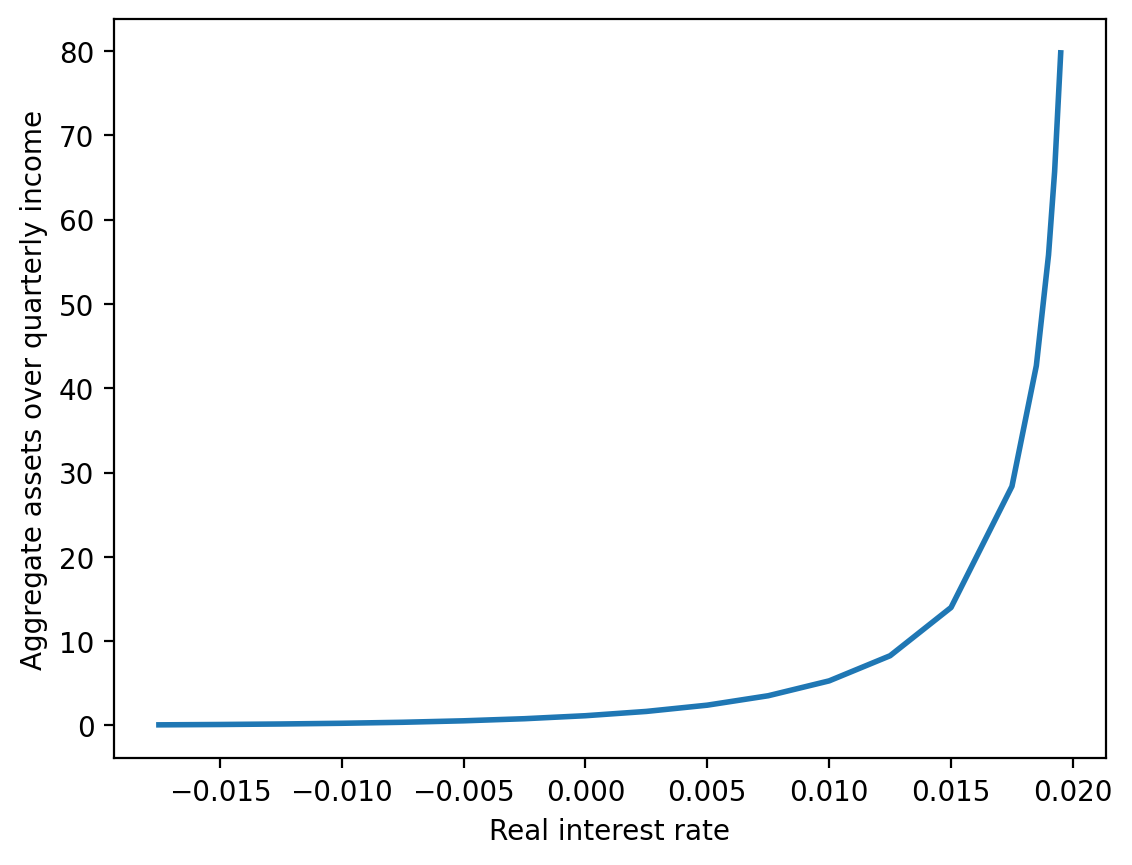

In [6]:
plt.plot(rs, As, linewidth=2)
plt.xlabel('Real interest rate')
plt.ylabel('Aggregate assets over quarterly income');

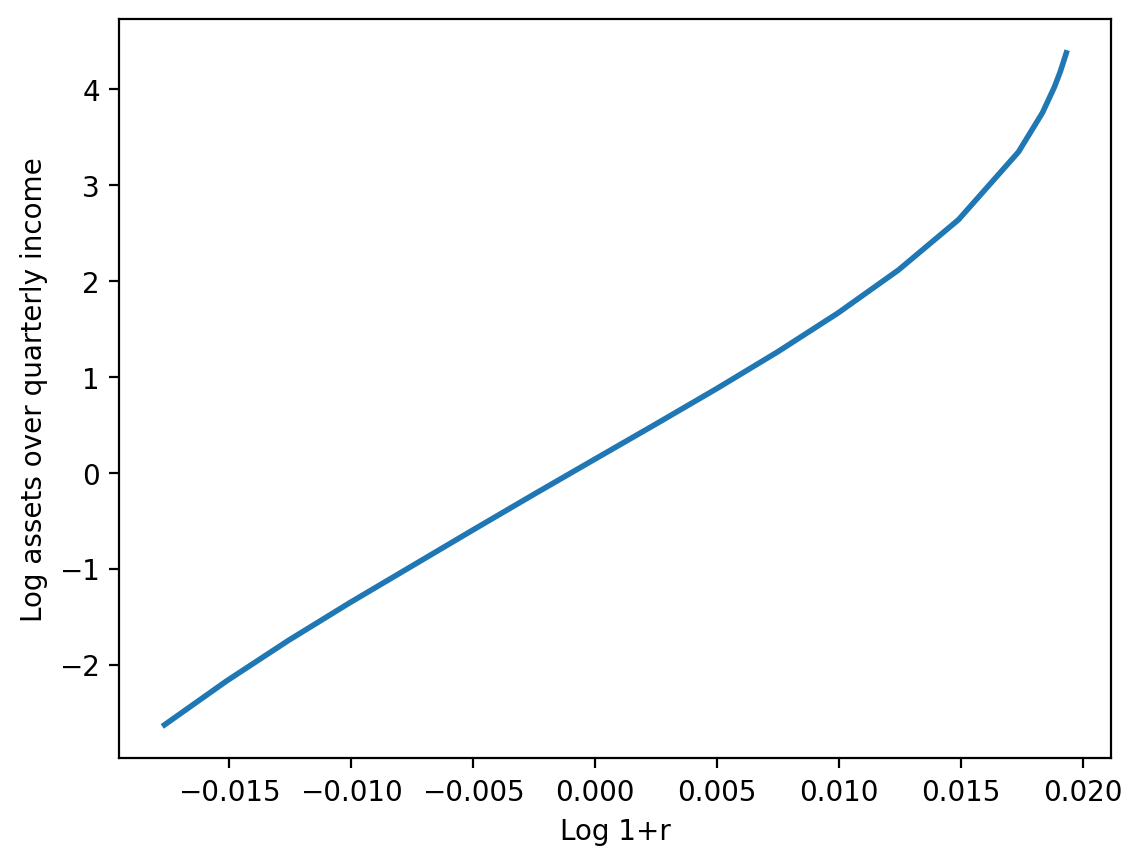

In [7]:
plt.plot(np.log(1+rs), np.log(As), linewidth=2)
plt.xlabel('Log 1+r')
plt.ylabel('Log assets over quarterly income');

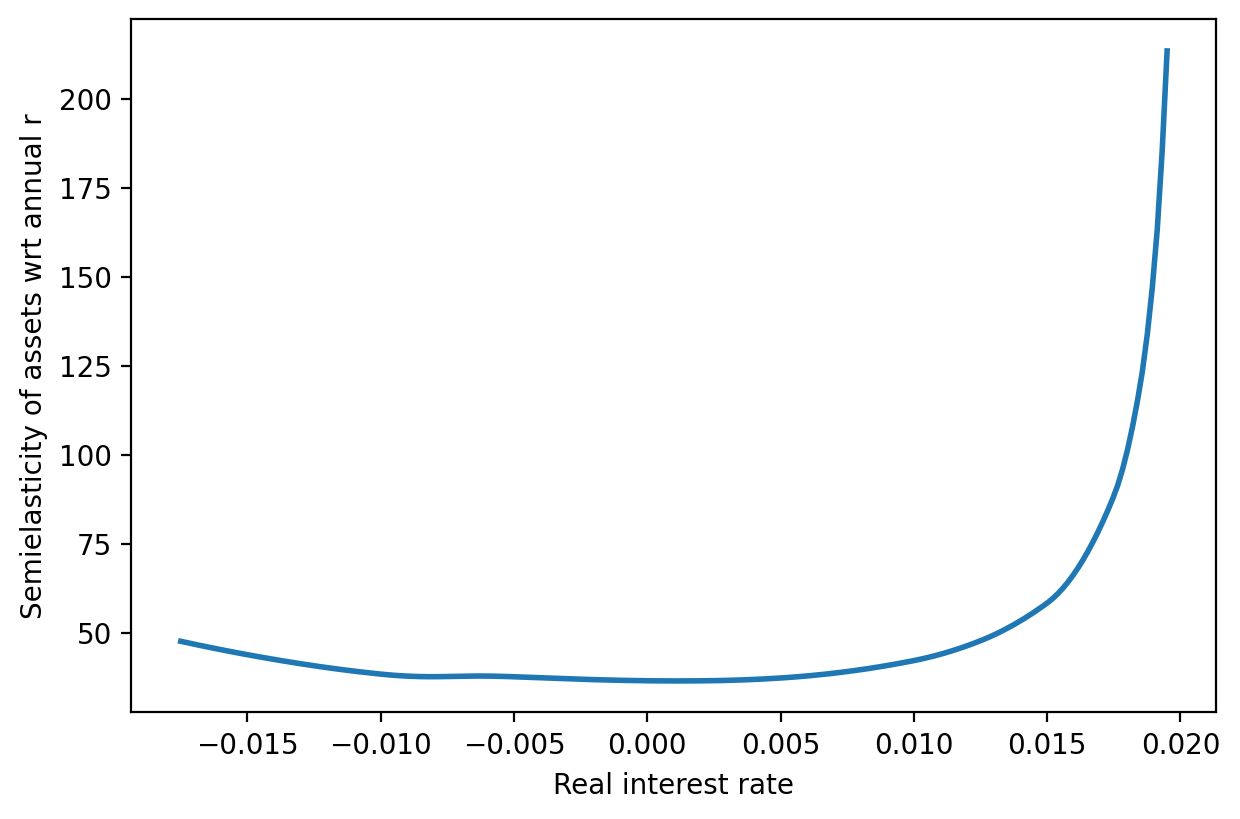

In [8]:
plt.figure(figsize=(7, 4.5))
logA_r = interpolate.CubicSpline(rs, np.log(As))
semielast = logA_r.derivative()
rs_big = np.linspace(rs[0], rs[-1], 200)
plt.plot(rs_big, semielast(rs_big)/4, linewidth=2) # divide by 4 to get semielasticity wrt annual r (standard units)
plt.xlabel('Real interest rate')
plt.ylabel('Semielasticity of assets wrt annual r');

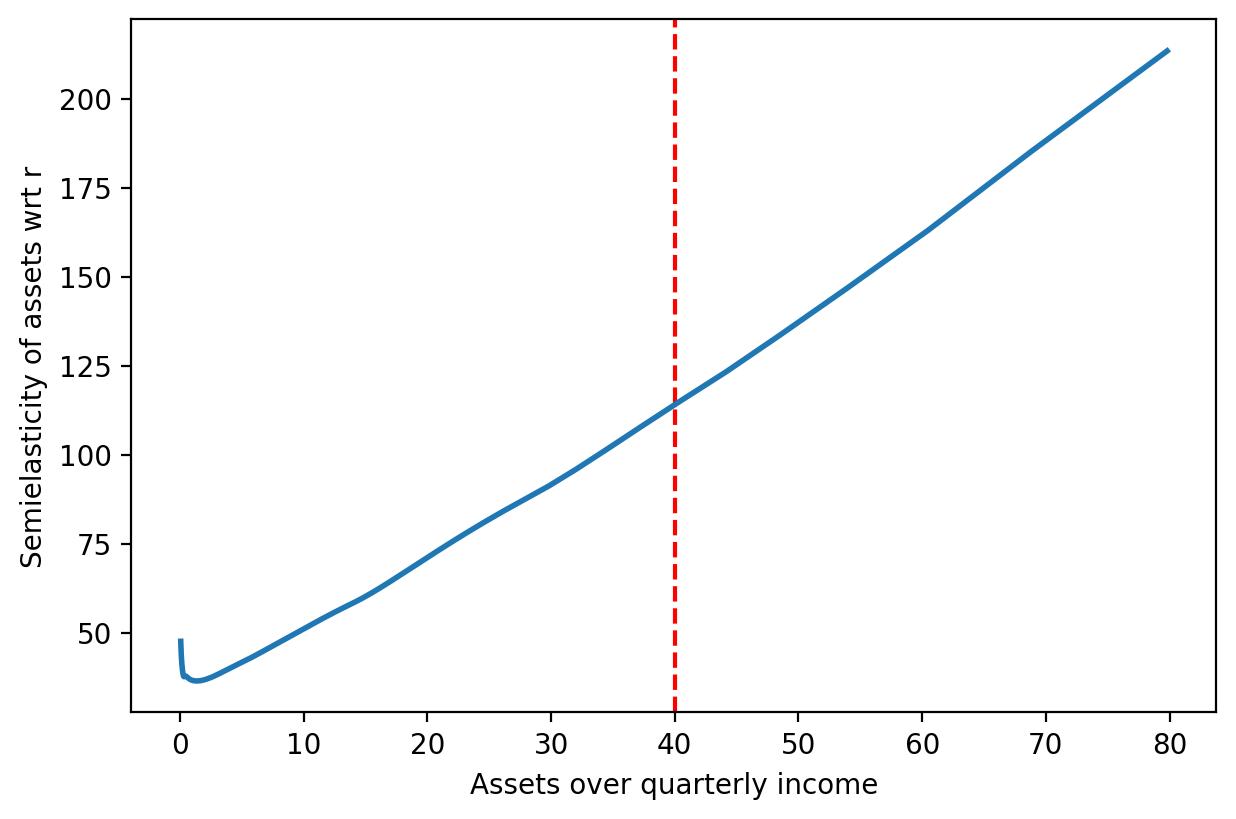

In [9]:
plt.figure(figsize=(7, 4.5))
logA_r = interpolate.CubicSpline(rs, np.log(As))
semielast = logA_r.derivative()
rs_big = np.linspace(rs[0], rs[-1], 200)
plt.axvline(40, color='red', linestyle='--')
plt.plot(np.exp(logA_r(rs_big)), semielast(rs_big)/4, linewidth=2)
plt.xlabel('Assets over quarterly income')
plt.ylabel('Semielasticity of assets wrt r');

## Point 2: what is the average MPC?

In [10]:
def get_mpc(ss):
    a, c, a_grid, r, D = ss['a'], ss['c'], ss['a_grid'], ss['r'], ss['D']
    mpcs = np.empty_like(c)

    # symmetric differences away from boundaries
    mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a_grid[2:] - a_grid[:-2]) / (1+r)

    # asymmetric first differences at boundaries
    mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a_grid[1] - a_grid[0]) / (1+r)
    mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a_grid[-1] - a_grid[-2]) / (1+r)

    # special case of constrained
    mpcs[a == a_grid[0]] = 1

    # aggregate at end
    return np.vdot(D, mpcs)

In [11]:
MPCs = [get_mpc(sim.steady_state(**{**calib, 'r': r})) for r in rs]

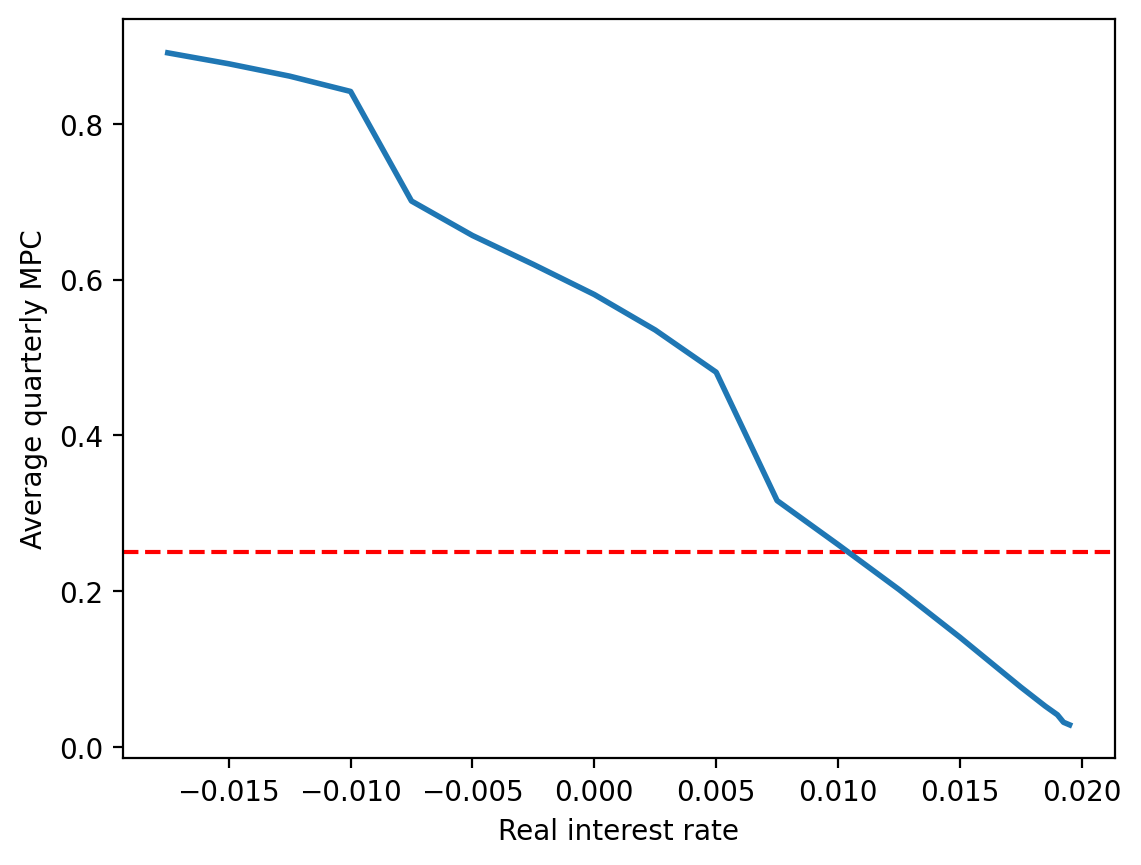

In [12]:
plt.axhline(0.25, color='red', linestyle='--')
plt.plot(rs, MPCs, linewidth=2)
plt.xlabel('Real interest rate')
plt.ylabel('Average quarterly MPC');

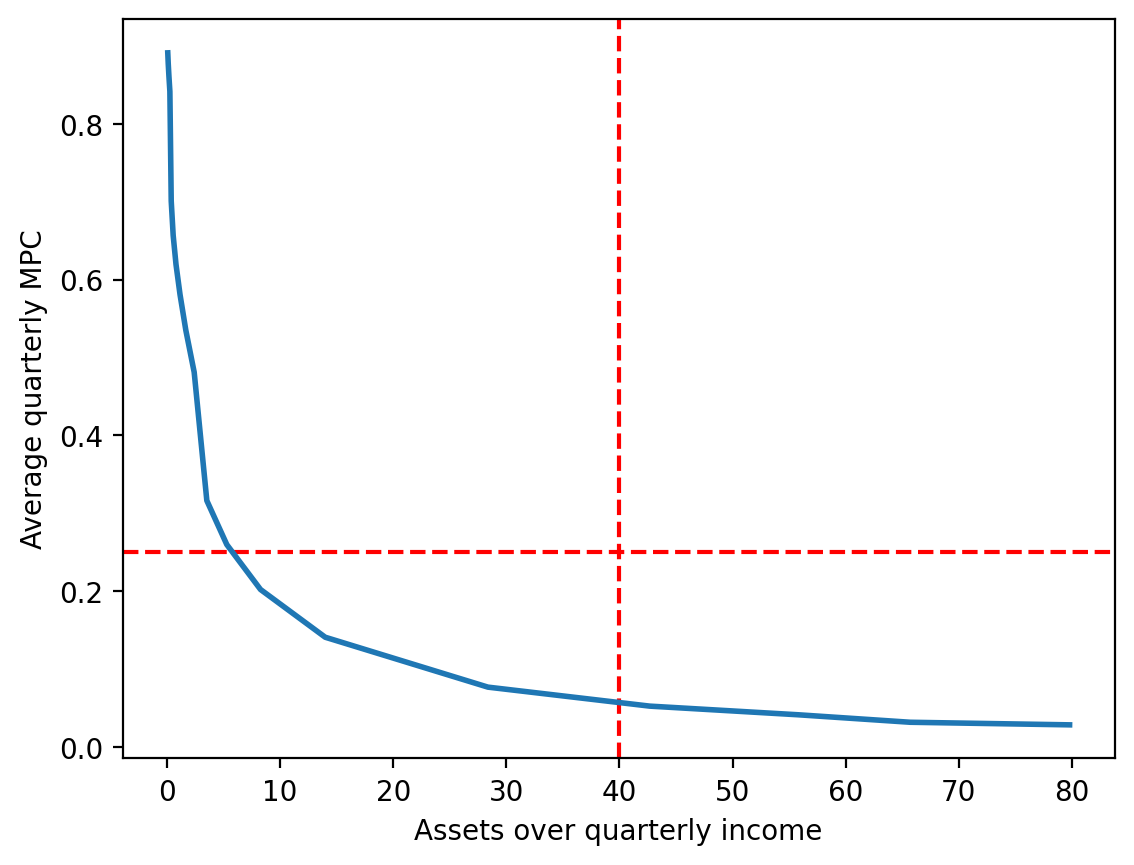

In [13]:
plt.axhline(0.25, color='red', linestyle='--')
plt.axvline(40, color='red', linestyle='--')
plt.plot(As, MPCs, linewidth=2)
plt.xlabel('Assets over quarterly income')
plt.ylabel('Average quarterly MPC');

In [14]:
As[14], As[15]

(28.376069557501253, 42.68081517804548)

In [15]:
MPCs[14], MPCs[15]

(0.07678878087615446, 0.05240564093107049)

In [16]:
ss['beta']

0.98

## Point 3: how much wealth inequality is there?

In [17]:
def lorenz_and_gini(d, grid):
    """Calculate the piecewise linear Lorenz curve and Gini coefficient
    for some distribution with point masses given by 'd' and levels given
    by 'grid'. (Written generically but with wealth or income in mind)"""
    
    # percentiles of people and of total assets
    x = d.cumsum()
    y = (d * grid).cumsum() / (d @ grid)
    assert np.isclose(x[-1], 1) and np.isclose(y[-1], 1)
    
    # add 0s at beginning to get full Lorenz curve
    x, y = np.concatenate(([0], x)), np.concatenate(([0], y))
    
    # trapezoidal rule to integrate
    S = (x[1:] - x[:-1]) @ (y[:-1] + y[1:]) / 2
    gini = 2*(1/2 - S)
    
    # return pointwise Lorenz curve and Gini
    return (x, y), gini

In [18]:
ss = sim.steady_state(**sim.example_calibration())
(x, y), gini = lorenz_and_gini(ss['D'].sum(axis=0), ss['a_grid'])

In [19]:
gini

0.8324033190321268

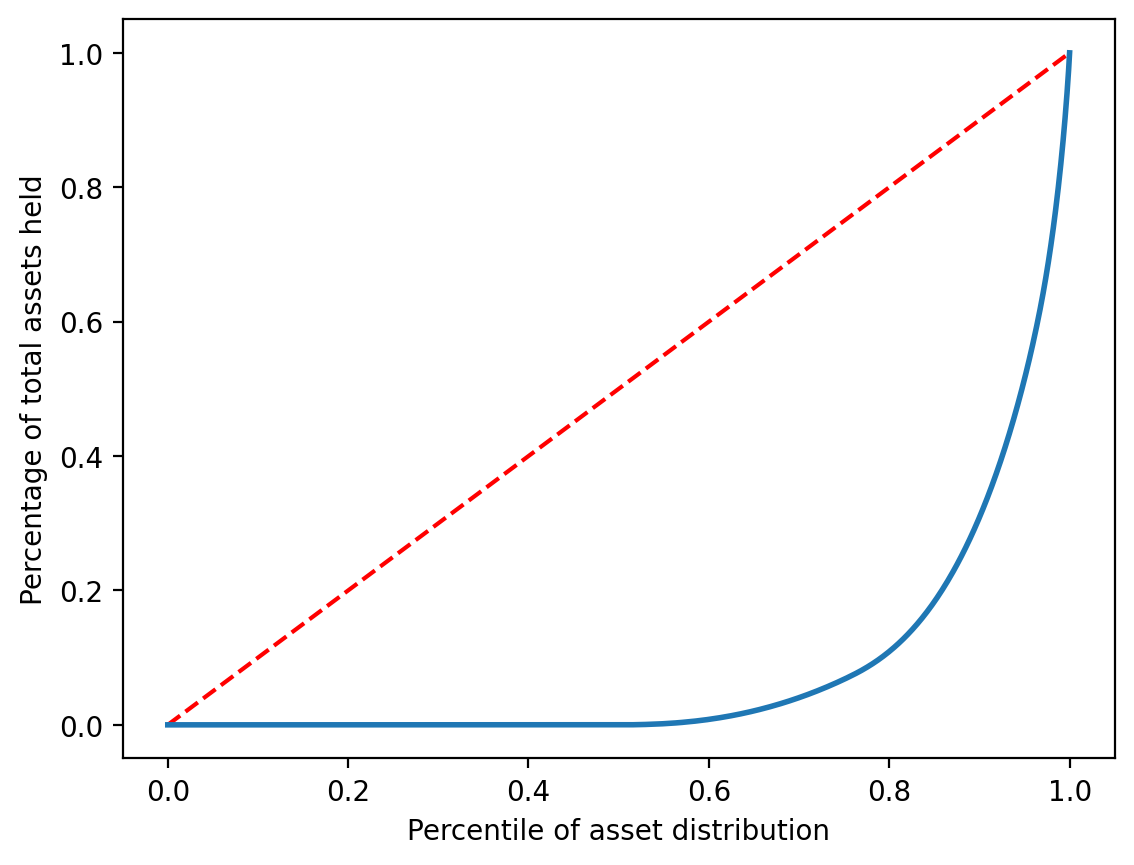

In [20]:
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.plot(x, y, linewidth=2)
plt.xlabel('Percentile of asset distribution')
plt.ylabel('Percentage of total assets held');

In [21]:
gini

0.8324033190321268